In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import msprime
import numpy as np
import seaborn as sns
import multiprocessing
import matplotlib.pyplot as plt

from IPython.display import SVG

# Introgression 

We examine a very simple example of Neanderthal introgression.

**TODO** intro blurb on this.

First we set our our highly over-simplified and idealised model, and run the simulation:

In [2]:
africa, europe, neanderthal = 0, 1, 2
time_units = 1000 / 25  # Conversion factor for kya to generations
ts = msprime.simulate(
    Ne=10**4,  # The same for all populations; highly unrealistic!
    recombination_rate=1e-8,
    length=100*10**6,  # 100 Mb
    samples=[
        msprime.Sample(time=0, population=africa),
        msprime.Sample(time=0, population=europe),
        # Neanderthal sample taken 30 kya
        msprime.Sample(time=30 * time_units, population=neanderthal),
    ],
    population_configurations = [
        msprime.PopulationConfiguration(), # Africa
        msprime.PopulationConfiguration(), # Europe
        msprime.PopulationConfiguration(), # Neanderthal
    ],
    demographic_events = [
        msprime.MassMigration(
            # 2% introgression 50 kya
            time=50 * time_units,
            source=europe, destination=neanderthal,            
            proportion=0.02),
        msprime.MassMigration(
            # European & Africa populations merge 70 kya
            time=70 * time_units,
            source=europe, destination=africa, proportion=1),
        msprime.MassMigration(
            # Neanderthal and African populations merge 300 kya
            time=300 * time_units,
            source=neanderthal, destination=africa, proportion=1),
    ],
    record_migrations=True,  # Needed for tracking segments.
)


Here we run our simulation in the usual way, including the ``record_migrations``. This allows us to track the actual segments of ancestral material that migrate from the European population into the Neanderthal population (backwards in time). We can then examine the length distributions of these segments and compare them with the length of the segments that also go on to coalesce within the Neanderthal population.

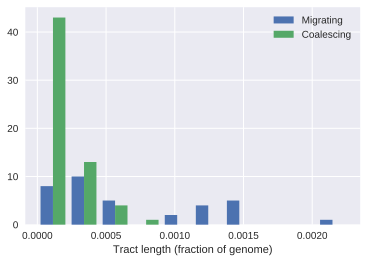

In [18]:
migrating_tracts = []
# Get all tracts that migrated into the neanderthal population
for migration in ts.migrations():
    if migration.dest == neanderthal:
        migrating_tracts.append(migration.right - migration.left)
migrating_tracts = np.array(migrating_tracts) / ts.sequence_length

coalescing_tracts = []
tract_left = None
for tree in ts.trees():    
    # 1 is the European sample and 2 is the Neanderthal
    mrca_pop = tree.population(tree.mrca(1, 2))
    left = tree.interval[0]
    if mrca_pop == neanderthal and tract_left is None:
        # Start a new tract
        tract_left = left      
    elif mrca_pop != neanderthal and tract_left is not None:
        # End the last tract
        coalescing_tracts.append(left - tract_left)
        tract_left = None
if tract_left is not None:
    coalescing_tracts.append(ts.sequence_length - tract_left)
coalescing_tracts = np.array(coalescing_tracts) / ts.sequence_length

plt.hist([migrating_tracts, coalescing_tracts], label=["Migrating", "Coalescing"])
plt.legend()
plt.xlabel("Tract length (fraction of genome)");


We build these tract length distributions by using the ``migrations`` and ``edges`` iterators. We first scan all the migration records (which consist of the left and right coordinates of the migrating ancestral segment; the source and destination demes; the migrating tree node; and the time of the migration event) to find those in which the destination was the Neanderthal population. Given our simple demographic model above, this can only as as result of the introgression event, giving us a simple way to find the segments that actually introgressed.  We find the tract lengths of the coalescing segments by iterating over the trees and looking at where the MRCA of the European and the Neanderthal samples was born. 

Plotting these tract lengths for a single replicate shows that, as expected, the coalescing tracts are substantially shorter than those that initially introgressed.